In [1]:
## import libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
from torch.utils.data import Subset
from torch import optim
!pip install syft
import torch.nn.functional as F
from syft.frameworks.torch.differential_privacy import pate
import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 194kB 2.8MB/s 
     |████████████████████████████████| 204kB 62.1MB/s 
     |████████████████████████████████| 71kB 29.5MB/s 
     |████████████████████████████████| 450kB 58.7MB/s 
     |████████████████████████████████| 389kB 52.6MB/s 
     |████████████████████████████████| 1.4MB 54.6MB/s 
     |████████████████████████████████| 51kB 27.2MB/s 
     |████████████████████████████████| 276kB 60.8MB/s 
     |████████████████████████████████| 122kB 51.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/ad/9a/f4/3105b5209674ac77fcca7fede95184c62a95df0196888e0e76
  Stored in directory: /root/.cache/pip/wheels/16/27/a1/775c62ddea7bfa62324fd1f65847ed31c55dadb6051481ba3f
Successfully built zstd pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


W0622 07:27:04.745247 140611178895232 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/usr/local/lib/python3.6/dist-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0-rc1.so'
W0622 07:27:04.760513 140611178895232 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
# check for GPU compatibility
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load `PUBLIC` and `PRIVATE` datasets with `torchvision`


**`PRIVATE DATA`**: **train_data**; This is the dataset we want to anonymize. 10 independent teacher models will be trained on 10 different partitions of this dataset

**`PUBLIC DATA`**: **test_data**; This is the dataset upon which we will assign labels; then retrain a model on top of it and then predict on its subset.

In [3]:
# batch size
batch_size = 64

# apply data transformation strategies
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# download and transform training and test sets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

  0%|          | 16384/9912422 [00:00<01:30, 109638.74it/s]

9920512it [00:00, 28852367.09it/s]                          


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 451069.11it/s]
  1%|          | 16384/1648877 [00:00<00:11, 143623.98it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 6931482.94it/s]                           
8192it [00:00, 183252.92it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


## PREPARE PRIVATE DATA FOR 100 DIFFERENT TEACHERS/MODELS

In [0]:
##Divide training data among teachers

# number of teachers
num_teachers = 100

# list to store dataloaders
teacher_loaders = []

# data-points per loader
data_size = len(train_data) // num_teachers

# iterate 
for i in range(num_teachers):
    # indices 
    indices = list(range(i*data_size, (i+1) *data_size))
    # subset data acc. to indices
    subset_data = Subset(train_data, indices)
    # convert to dataloader format
    loader = torch.utils.data.DataLoader(subset_data, batch_size=batch_size, num_workers=2)
    teacher_loaders.append(loader)

In [5]:
teacher_loaders

In [0]:
## DL model

class FCN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x

In [0]:
## FUNCTION for calculating accuracy

def evaluate(dataloader, model):
    total, correct = 0, 0
    # iterate over dataloader
    for data in dataloader:
        # capture and move to GPU
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # predict
        outputs = model(inputs)
        # predicted labels
        _, pred = torch.max(outputs.data, 1)
        # total data points
        total += labels.size(0)
        # correctly predicted
        correct += (pred == labels).sum().item()
    return 100 * (correct / total)

In [8]:
# models
models = []
# total loss
total_loss = []
# iterate over every teacher data
for t in range(len(teacher_loaders)):
  print("Training TEACHER", t+1)
  # training loss
  teacher_loss = [] 
  # initialize teacher model
  teacher_model = FCN()
  # move model to GPU
  teacher_model.to(device)
  # loss
  criterion = nn.CrossEntropyLoss()
  # optimizer
  opt = optim.SGD(teacher_model.parameters(), lr=0.01)
  # dataloader
  dataloader = teacher_loaders[t]
  for e in range(200):
    running_loss = 0
    # images and labels
    for images, labels in dataloader:
      # migrate to GPU
      images, labels = images.to(device), labels.to(device)
      # zero previous gradients
      opt.zero_grad()
      # make predictions
      outputs = teacher_model(images)
      # calculate loss
      loss = criterion(outputs, labels)
      # backpropagate
      loss.backward()
      # weight update
      opt.step()
      # loss update
      teacher_loss.append(loss.item())
      running_loss += loss.item()
  print("Loss at the end of training teacher model {} is {}".format(t+1, running_loss))
  total_loss.append(teacher_loss[-1])
  models.append(teacher_model)
  teacher_model.eval()
  acc = evaluate(dataloader, teacher_model)
  print("Accuracy for model {} is {}".format(t+1, acc))
  print('='*50)

Training TEACHER 1
Loss at the end of training teacher model 1 is 0.6280012037605047
Accuracy for model 1 is 99.5
Training TEACHER 2
Loss at the end of training teacher model 2 is 1.0914640594273806
Accuracy for model 2 is 97.66666666666667
Training TEACHER 3
Loss at the end of training teacher model 3 is 0.9098032470792532
Accuracy for model 3 is 98.33333333333333
Training TEACHER 4
Loss at the end of training teacher model 4 is 0.5225329529494047
Accuracy for model 4 is 99.66666666666667
Training TEACHER 5
Loss at the end of training teacher model 5 is 0.6504762172698975
Accuracy for model 5 is 99.5
Training TEACHER 6
Loss at the end of training teacher model 6 is 0.4540586471557617
Accuracy for model 6 is 100.0
Training TEACHER 7
Loss at the end of training teacher model 7 is 0.8544202446937561
Accuracy for model 7 is 98.66666666666667
Training TEACHER 8
Loss at the end of training teacher model 8 is 0.6294894963502884
Accuracy for model 8 is 99.33333333333333
Training TEACHER 9
Los

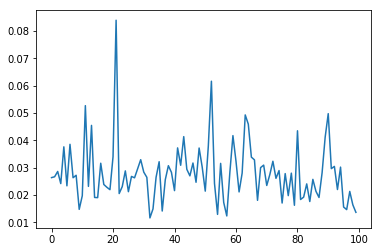

In [9]:
plt.plot(total_loss)
plt.show()

In [10]:
models

[FCN(
   (fc1): Linear(in_features=784, out_features=256, bias=True)
   (fc2): Linear(in_features=256, out_features=128, bias=True)
   (fc3): Linear(in_features=128, out_features=64, bias=True)
   (fc4): Linear(in_features=64, out_features=10, bias=True)
 ), FCN(
   (fc1): Linear(in_features=784, out_features=256, bias=True)
   (fc2): Linear(in_features=256, out_features=128, bias=True)
   (fc3): Linear(in_features=128, out_features=64, bias=True)
   (fc4): Linear(in_features=64, out_features=10, bias=True)
 ), FCN(
   (fc1): Linear(in_features=784, out_features=256, bias=True)
   (fc2): Linear(in_features=256, out_features=128, bias=True)
   (fc3): Linear(in_features=128, out_features=64, bias=True)
   (fc4): Linear(in_features=64, out_features=10, bias=True)
 ), FCN(
   (fc1): Linear(in_features=784, out_features=256, bias=True)
   (fc2): Linear(in_features=256, out_features=128, bias=True)
   (fc3): Linear(in_features=128, out_features=64, bias=True)
   (fc4): Linear(in_features=64,

## Public Dataset

In [0]:
## Data will be labelled with laplacian noise to anonymize private data
## Unlabelled data-points will be labelled by an aggregating all teacher models
## New DL model will be trained on this labelled data
student_train_data = Subset(test_data, list(range(9000)))
student_train_loader = torch.utils.data.DataLoader(student_train_data, batch_size=batch_size, 
            num_workers=4)


## TEST DATA WHERE WE MAKE FINAL PREDICTIONS 
## ACCURACY WILL BE MEASURED
student_test_data = Subset(test_data, list(range(9000, 10000)))
student_test_loader = torch.utils.data.DataLoader(student_test_data, batch_size=batch_size, 
            num_workers=4)

In [0]:
## PREDICT WITH DL MODEL function

def predict(model, dataloader):
    
    outputs = torch.zeros(0, dtype=torch.long).to(device)
    # migrate to GPU
    model.to(device)
    # set to evaluation mode
    model.eval()
    # true labels
    true_labels = torch.zeros(0, dtype=torch.long).to(device)
    # iterate over batch
    for images, labels in dataloader:
        # migrate to GPU
        images, labels = images.to(device), labels.to(device)
        # predict
        output = model(images)
        # pick up index with max. value
        ps = torch.argmax(torch.exp(output), dim=1)
        # append to "outputs" torch array
        outputs = torch.cat((outputs, ps))
        true_labels = torch.cat((true_labels, labels))
    
    return outputs, true_labels

## ADD LAPLACIAN NOISE AND AGGREGRATE MODELS

STEPS:
- Make predictions for each of the 10 models on the unlabelled public data i.e. `student_train_loader`. 
- Find out predicted labels and add **laplacian noise** for a certain **epsilon-delta** constraint for generating new labels.

In [0]:
# list to store predictions on unlabelled public data
preds = torch.torch.zeros((len(models), 9000), dtype=torch.long)
gt_labels = torch.torch.zeros((len(models), 9000), dtype=torch.long)

# iterate
for i, model in enumerate(models):
    # predict on unlabelled public data
    pred, true_labels = predict(model, student_train_loader)
    preds[i] = pred
    gt_labels[i] = true_labels

    

# list to store new labels post laplacian noise addition
labels = []


for pred in preds.transpose(1,0):
    
    # value counts for every label
    label_counts = np.bincount(pred, minlength=10)
    # calculate beta
    beta = 1 / 0.1                              # (epsilon=0.1)
    # iterate to add laplacian noise
    for i in range(len(label_counts)):
        label_counts[i] += np.random.laplace(0, beta, 1)
    
    # catch image with max occurence
    new_label = np.argmax(label_counts)
    # add to list
    labels.append(new_label)

In [22]:
print(preds, type(preds))
print(labels, type(labels))
print(gt_labels, type(gt_labels))

tensor([[7, 2, 1,  ..., 6, 9, 0],
        [7, 5, 1,  ..., 6, 9, 0],
        [7, 2, 1,  ..., 6, 9, 0],
        ...,
        [7, 2, 1,  ..., 6, 9, 0],
        [7, 2, 1,  ..., 6, 9, 0],
        [7, 2, 1,  ..., 6, 9, 0]]) <class 'torch.Tensor'>
[7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 4, 2, 7, 4, 2, 4, 3, 0, 7, 0, 2, 1, 1, 7, 5, 7, 9, 7, 9, 6, 2, 7, 8, 4, 7, 5, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 1, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 9, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 4, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 7, 1, 4, 4, 7, 3, 3, 2, 1, 1, 8, 1, 8, 1, 8, 5, 0, 8, 4, 2, 5, 0, 1, 1, 1, 0, 9, 0, 5, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0, 3, 5, 7, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 7, 7, 7, 2, 2, 4, 1, 5, 8, 8, 9, 2, 5, 0, 6, 4, 2, 4, 1, 9,

In [0]:
# convert to NumPy arrays
labels = np.array(labels)
preds = preds.numpy()

In [24]:
# How many labels are intact even after noise addition?
(gt_labels[0].cpu().numpy() == labels).sum()

7950

## Perform PATE Analysis

In [25]:
data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=preds, indices=labels, noise_eps=0.35, delta=1e-5)
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compute sensitivity
l too large to compu

## Training on student data

This time we will be training a new DL on `student_train_loader`

In [26]:
labels

array([7, 2, 1, ..., 6, 9, 0])

In [27]:
# model
student_model = FCN()
# migrate to GPU
student_model.to(device)
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
opt = optim.SGD(student_model.parameters(), lr=0.1)
# no. of epochs
epochs = 100
# tracking params
epoch_loss = []

for e in range(epochs):
    running_loss = 0
    # model in training mode, dropout is on
    student_model.train()
    # load data 
    for idx, (images, _) in enumerate(student_train_loader):
        true_labels = labels[idx*len(images):(idx+1)*len(images)]
        images, true_labels = images.to(device), torch.Tensor(true_labels).to(device).long()
        # make gradients zero
        opt.zero_grad()
        # predict
        output = student_model(images)
        # calculate loss
        loss = criterion(output, true_labels)
        # backpropagate
        loss.backward()
        # update weights
        opt.step()
        # append loss
        running_loss += loss.item()
    epoch_loss.append(running_loss)
    print("Training loss at epoch {} is {}".format(e+1, running_loss))
    print('='*100)

Training loss at epoch 1 is 219.26726633310318
Training loss at epoch 2 is 83.27748719602823
Training loss at epoch 3 is 54.68108781427145
Training loss at epoch 4 is 46.10930620133877
Training loss at epoch 5 is 40.63496529683471
Training loss at epoch 6 is 37.02338645234704
Training loss at epoch 7 is 34.194322522729635
Training loss at epoch 8 is 31.531500317156315
Training loss at epoch 9 is 30.031231373548508
Training loss at epoch 10 is 28.862612184137106
Training loss at epoch 11 is 27.414849933236837
Training loss at epoch 12 is 26.825276397168636
Training loss at epoch 13 is 24.791556734591722
Training loss at epoch 14 is 24.057858284562826
Training loss at epoch 15 is 24.245449852198362
Training loss at epoch 16 is 23.22989694774151
Training loss at epoch 17 is 21.49493818357587
Training loss at epoch 18 is 20.205602940171957
Training loss at epoch 19 is 20.149153105914593
Training loss at epoch 20 is 20.084651235491037
Training loss at epoch 21 is 18.174119625240564
Training

## TEST ON STUDENT DATA i.e. `student_test_loader`

In [28]:
print(evaluate(student_test_loader, student_model))

88.9
